# PRISM_evaluation_figures

In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import numpy as np

# stats tools
from scipy.stats import pearsonr, spearmanr
from scipy.ndimage import gaussian_filter

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu


In [2]:
# import importlib
# importlib.reload(du)

In [3]:
%matplotlib inline

# Global settings

### File path and names

In [4]:
DATA_dir = PRISM_dir
RESULT_dir = save_dir
feature_name = 'PRISM_TMAX_features_2015_2020.hdf'

# result files
TMAX_PRED_name = 'PRISM_PRED_TMAX_2018_2020.hdf' #'OLD_results/PRISM_PRED_T2_2018_season.hdf'
TMIN_PRED_name = 'PRISM_PRED_TMIN_2018_2020.hdf' #'OLD_results/PRISM_PRED_T2_2018_season.hdf'
TMAX_baseline_name = 'BASELINE_PRISM_TMAX_2018_2020.hdf' #'OLD_results/MLR_T2_std_season.hdf'
TMIN_baseline_name = 'BASELINE_PRISM_TMIN_2018_2020.hdf' #'OLD_results/MLR_T2_std_season.hdf'

SAVE_dir = save_dir # place for backup temporaal files

### HDF keys

In [5]:
VARS = ['TMAX', 'TMIN']

# file keys (how variables are stored in the hdf files)
TMAX_keys = ['RESULT_UNET', 'RESULT_UAE', 'TMAX_REGRID', 'TMAX_4km'] 
# old keys: ['TMAX_REGRID', 'baseline', 'TMAX_A', 'TMAX_B', 'TMAX_TRUE']
TMIN_keys = ['RESULT_UNET', 'RESULT_UAE', 'TMIN_REGRID', 'TMIN_4km']
TMAX_baseline_key = 'OUT_no_clim' # old keys: 'TMAX_MLR'
TMIN_baseline_key = 'OUT_no_clim'
# calculation keys
TMAX_keys_pred = ['TMAX_REGRID', 'baseline', 'RESULT_UNET', 'RESULT_UAE', 'TMAX_4km']
TMIN_keys_pred = ['TMIN_REGRID', 'baseline', 'RESULT_UNET', 'RESULT_UAE', 'TMIN_4km']
# key elements subtraction
LR_TMAX_key = TMAX_keys_pred[0]
LR_TMIN_key = TMIN_keys_pred[0]
HR_TMAX_key = TMAX_keys_pred[-1]
HR_TMIN_key = TMIN_keys_pred[-1]
# other keys
domains = ['train', 'trans']
seasons = ['djf', 'mam', 'jja', 'son']

### Time range and domain

In [6]:
# available time range of the file (2018-2019) <----- support 2020 test in the furture 
N_all = 365
all_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# time range for plotting (2018-2019)
N_pred = 365
pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# indices
ind_pred = du.dt_match(all_list, pred_list)
ind_sea = du.season_ind_sep(pred_list, key_format='{}')

# remove all-nans at the edge of the domain
pad = -15 # remove some edging grid points

# histogram value range (degree C)
TMAX_LIM = 18
TMIN_LIM = 15 # TMIN has lower range
N_hist = 150 # hist bins = 150

In [7]:
# # If baeseline and other results have different prediction time range
# # <------ !!!! fixed
# # **************************************************************** #
# N_all = 365 + 365
# all_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_all)]
# # time range for plotting (2018-2019)
# N_pred = 365
# pred_list = [datetime(2018, 1, 1, 0) + timedelta(days=x) for x in range(N_pred)]
# # indices
# ind_pred_baseline = du.dt_match(all_list, pred_list)
# # **************************************************************** #

In [8]:
with h5py.File(DATA_dir+feature_name, 'r') as hdf_io:
    lon = hdf_io['lon_4km'][...]
    lat = hdf_io['lat_4km'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]
    land_mask = hdf_io['land_mask'][...]

### Graphic settings

In [9]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

In [10]:
cmap_mae = plt.cm.plasma_r # MAE colormap
cmap_line = plt.cm.plasma_r # line color "base"
camp_tmax_hist = plt.cm.plasma_r # TMAX histogram colormap
camp_tmin_hist = plt.cm.viridis_r # TMIN histogram colormap
camp_t2 = gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r)

line_colors = [cmap_line(45), cmap_line(90), cmap_line(135), cmap_line(180), cmap_line(225)]

In [11]:
fake_t = np.arange(N_pred) # replacement of datetime array

**Export settings**

In [12]:
fig_keys = {'dpi':250, 
            'orientation':'portrait', 
            'papertype':'a4',
            'bbox_inches':'tight', 
            'pad_inches':0, 
            'transparent':True}

# Data and calculations

In [13]:
TMAX = {}
with h5py.File(RESULT_dir+TMAX_PRED_name, 'r') as hdf_io:
    for key in TMAX_keys:
        temp = hdf_io[key][ind_pred, ...]
        temp[:, land_mask] = np.nan
        TMAX[key] = temp
with h5py.File(RESULT_dir+TMAX_baseline_name, 'r') as hdf_io:
    temp = hdf_io[TMAX_baseline_key][ind_pred, ...]
    temp[:, land_mask] = np.nan
    TMAX['baseline'] = temp
    
TMIN = {}
with h5py.File(RESULT_dir+TMIN_PRED_name, 'r') as hdf_io:
    for key in TMIN_keys:
        temp = hdf_io[key][ind_pred, ...]
        temp[:, land_mask] = np.nan
        TMIN[key] = temp
with h5py.File(RESULT_dir+TMIN_baseline_name, 'r') as hdf_io:
    temp = hdf_io[TMIN_baseline_key][ind_pred, ...]
    temp[:, land_mask] = np.nan
    TMIN['baseline'] = temp

### Histogram calculation

In [14]:
RES_TMAX = {}
RES_TMIN = {}

HIST_TMAX = {}
HIST_TMIN = {}

HIST_TMAX_keys = TMAX_keys_pred[1:4] # baseline, UNet, UNet-AE
HIST_TMIN_keys = TMIN_keys_pred[1:4]

for key in TMAX_keys_pred[1:]:
    for sea in seasons:
        RES_TMAX['{}_{}_train'.format(key, sea)] = TMAX[key][ind_sea[sea], :ind_trans, :].ravel()-\
                                                   TMAX[LR_TMAX_key][ind_sea[sea], :ind_trans, :].ravel()
        RES_TMAX['{}_{}_trans'.format(key, sea)] = TMAX[key][ind_sea[sea], ind_trans:pad, :].ravel()-\
                                                   TMAX[LR_TMAX_key][ind_sea[sea], ind_trans:pad, :].ravel()
for key in TMIN_keys_pred[1:]:
    for sea in seasons:
        RES_TMIN['{}_{}_train'.format(key, sea)] = TMIN[key][ind_sea[sea], :ind_trans, :].ravel()-\
                                                   TMIN[LR_TMIN_key][ind_sea[sea], :ind_trans, :].ravel()
        RES_TMIN['{}_{}_trans'.format(key, sea)] = TMIN[key][ind_sea[sea], ind_trans:pad, :].ravel()-\
                                                   TMIN[LR_TMIN_key][ind_sea[sea], ind_trans:pad, :].ravel()

for key in HIST_TMAX_keys:
    for sea in seasons:
        for dom in domains:
            # one for bin counts, the other one for probabilities
            X, Y, H = vu.hist2dxy(RES_TMAX['{}_{}_{}'.format(key, sea, dom)], 
                                  RES_TMAX['{}_{}_{}'.format(HR_TMAX_key, sea, dom)], 
                                  1e-3, TMAX_LIM, Xnum=N_hist, Ynum=N_hist, density=False)
            
            _, _, P = vu.hist2dxy(RES_TMAX['{}_{}_{}'.format(key, sea, dom)], 
                                  RES_TMAX['{}_{}_{}'.format(HR_TMAX_key, sea, dom)], 
                                  1e-3, TMAX_LIM, Xnum=N_hist, Ynum=N_hist, density=True) # <-- True
            
            HIST_TMAX['{}_{}_{}_X'.format(key, sea, dom)] = X
            HIST_TMAX['{}_{}_{}_Y'.format(key, sea, dom)] = Y
            HIST_TMAX['{}_{}_{}_H'.format(key, sea, dom)] = H
            HIST_TMAX['{}_{}_{}_P'.format(key, sea, dom)] = P
            
for key in HIST_TMIN_keys:
    for sea in seasons:
        for dom in domains:
            # one for bin counts, the other one for probabilities
            X, Y, H = vu.hist2dxy(RES_TMIN['{}_{}_{}'.format(key, sea, dom)], 
                                  RES_TMIN['{}_{}_{}'.format(HR_TMIN_key, sea, dom)], 
                                  0, TMIN_LIM, Xnum=N_hist, Ynum=N_hist, density=False)
            
            _, _, P = vu.hist2dxy(RES_TMIN['{}_{}_{}'.format(key, sea, dom)], 
                                  RES_TMIN['{}_{}_{}'.format(HR_TMIN_key, sea, dom)], 
                                  0, TMIN_LIM, Xnum=N_hist, Ynum=N_hist, density=True) # <-- True
            
            HIST_TMIN['{}_{}_{}_X'.format(key, sea, dom)] = X
            HIST_TMIN['{}_{}_{}_Y'.format(key, sea, dom)] = Y
            HIST_TMIN['{}_{}_{}_H'.format(key, sea, dom)] = H
            HIST_TMIN['{}_{}_{}_P'.format(key, sea, dom)] = P

### MAE calculation

In [15]:
TMAX['baseline'] = 0.2*TMAX['TMAX_REGRID'][...] + 0.8*TMAX['baseline'][...]
TMIN['baseline'] = 0.2*TMIN['TMIN_REGRID'][...] + 0.8*TMIN['baseline'][...]
TMAX['RESULT_UNET'] = 0.15*TMAX['TMAX_REGRID'][...] + 0.85*TMAX['RESULT_UNET'][...]
TMIN['RESULT_UNET'] = 0.15*TMIN['TMIN_REGRID'][...] + 0.85*TMIN['RESULT_UNET'][...]

**Spatial & temporal MAEs**

In [16]:
# TMAX_keys_pred[-1] is the HR PRISM
MAE_TMAX = {}
MAE_TMIN = {}
for key in TMAX_keys_pred[:-1]:
    # grid-point-wise MAE
    MAE_TMAX['{}_grid'.format(key)] = du.MAE_spatial(TMAX[key], TMAX[HR_TMAX_key])
    # domain averaged MAE
    MAE_TMAX['{}_trans'.format(key)] = du.MAE_temporal(TMAX[key][:, ind_trans:pad, :], TMAX[HR_TMAX_key][:, ind_trans:pad, :])
    MAE_TMAX['{}_train'.format(key)] = du.MAE_temporal(TMAX[key][:, :ind_trans, :], TMAX[HR_TMAX_key][:, :ind_trans, :])

for key in TMIN_keys_pred[:-1]:
    # grid-point-wise MAE
    MAE_TMIN['{}_grid'.format(key)] = du.MAE_spatial(TMIN[key], TMIN[HR_TMIN_key])
    # domain averaged MAE
    MAE_TMIN['{}_trans'.format(key)] = du.MAE_temporal(TMIN[key][:, ind_trans:pad, :], TMIN[HR_TMIN_key][:, ind_trans:pad, :])
    MAE_TMIN['{}_train'.format(key)] = du.MAE_temporal(TMIN[key][:, :ind_trans, :], TMIN[HR_TMIN_key][:, :ind_trans, :])

/glade/u/home/ksha/WORKSPACE/utils/data_utils.py:41: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.abs(X1-X2))


In [17]:
# ----- save MAEs to cache ----- #
np.save(SAVE_dir+'PRISM_TMAX_2019_MAE.npy', MAE_TMAX)
np.save(SAVE_dir+'PRISM_TMIN_2019_MAE.npy', MAE_TMIN)

In [18]:
# # ----- load MAEs from cache ----- #
# MAE_TMAX = np.load(SAVE_dir+'PRISM_TMAX_2019_MAE.npy', allow_pickle=True)[()]
# MAE_TMIN = np.load(SAVE_dir+'PRISM_TMIN_2019_MAE.npy', allow_pickle=True)[()]

**Seasonal MAE time series** 

In [19]:
TMAX_MAE_season = {}
TMIN_MAE_season = {}
# TMAX_keys_pred[-1] is the HR PRISM

# TMAX
for key in TMAX_keys_pred[:-1]:
    for sea in seasons:
        for dom in domains:
            TMAX_MAE_season['{}_{}_{}'.format(key, dom, sea)] = np.mean(MAE_TMAX['{}_{}'.format(key, dom)][ind_sea[sea]])
# TMIN
for key in TMIN_keys_pred[:-1]:
    for sea in seasons:
        for dom in domains:
            TMIN_MAE_season['{}_{}_{}'.format(key, dom, sea)] = np.mean(MAE_TMIN['{}_{}'.format(key, dom)][ind_sea[sea]])

### Laplacian calculation

In [20]:
TMAX_Lap = {} 
TMIN_Lap = {}

# TMAX discrete Laplacian
for key in TMAX_keys_pred:
    TMAX_Lap['{}_trans'.format(key)] = du.del_3d(TMAX['{}'.format(key)][:, ind_trans:pad, :])
    TMAX_Lap['{}_train'.format(key)] = du.del_3d(TMAX['{}'.format(key)][:, :ind_trans, :])

# TMIN
for key in TMIN_keys_pred:
    TMIN_Lap['{}_trans'.format(key)] = du.del_3d(TMIN['{}'.format(key)][:, ind_trans:pad, :])
    TMIN_Lap['{}_train'.format(key)] = du.del_3d(TMIN['{}'.format(key)][:, :ind_trans, :])

In [21]:
TMAX_Corr = {}
TMIN_Corr = {}
# keys
TMAX_keys_r = TMAX_keys_pred[1:4] # Corr. calculation for (baseline, UNet, UNet-AE) v.s. HR PRISM
TMIN_keys_r = TMIN_keys_pred[1:4]

for dom in domains:
    for i, key in enumerate(TMAX_keys_r):
        r, _ = pearsonr(TMAX_Lap['{}_{}'.format(key, dom)], TMAX_Lap['{}_{}'.format(HR_TMAX_key, dom)])
        TMAX_Corr['{}_{}'.format(key, dom)] = np.round(r, 3)
        
    for i, key in enumerate(TMIN_keys_r):    
        r, _ = pearsonr(TMIN_Lap['{}_{}'.format(key, dom)], TMIN_Lap['{}_{}'.format(HR_TMIN_key, dom)])
        TMIN_Corr['{}_{}'.format(key, dom)] = np.round(r, 3)

## Figures

## MAE verification

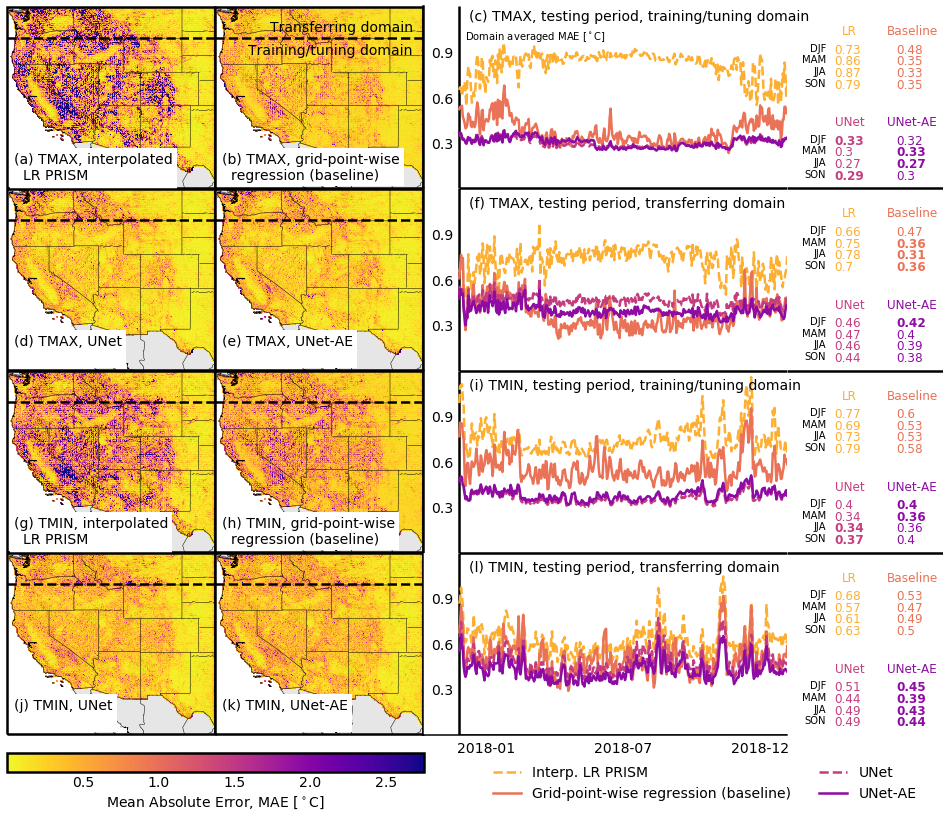

In [22]:
edge = [lon.min(), lon.max(), lat.min()+3, lat.max()-0.5]

fig = plt.figure(figsize=(13, 10.115))
gs = gridspec.GridSpec(4, 4, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1.75, 0.75])
ax_a1 = plt.subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax_a2 = plt.subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax_a3 = plt.subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax_a4 = plt.subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax_a5 = plt.subplot(gs[0, 2])
ax_a6 = plt.subplot(gs[1, 2])
ax_a7 = plt.subplot(gs[0, 3])
ax_a8 = plt.subplot(gs[1, 3])

ax_b1 = plt.subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax_b2 = plt.subplot(gs[2, 1], projection=ccrs.PlateCarree())
ax_b3 = plt.subplot(gs[3, 0], projection=ccrs.PlateCarree())
ax_b4 = plt.subplot(gs[3, 1], projection=ccrs.PlateCarree())
ax_b5 = plt.subplot(gs[2, 2])
ax_b6 = plt.subplot(gs[3, 2])
ax_b7 = plt.subplot(gs[2, 3])
ax_b8 = plt.subplot(gs[3, 3])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ===== pcolor panel macros ===== #
AX = [ax_a1, ax_a2, ax_a3, ax_a4, ax_b1, ax_b2, ax_b3, ax_b4]
# figure (b) domain description
ax_a2.text(0.95, 0.925, 'Transferring domain', fontsize=14, ha='right', va='top', transform=ax_a2.transAxes)
ax_a2.text(0.95, 0.8, 'Training/tuning domain', fontsize=14, ha='right', va='top', transform=ax_a2.transAxes)
# titles
pcolor_titles = ['(a) TMAX, interpolated\n  LR PRISM\n ', 
                 '(b) TMAX, grid-point-wise\n  regression (baseline)', 
                 '(d) TMAX, UNet\n ', 
                 '(e) TMAX, UNet-AE\n ',
                 '(g) TMIN, interpolated\n  LR PRISM\n ', 
                 '(h) TMIN, grid-point-wise\n  regression (baseline)', 
                 '(j) TMIN, UNet\n ', 
                 '(k) TMIN, UNet-AE\n ']
ptitle_loc = [0.0325, 0.2] # pcolor title position (bottom left) 
# ===== line graph macros ===== #
AX_line = [ax_a5, ax_a6, ax_b5, ax_b6]
# title
line_titles = ['(c) TMAX, testing period, training/tuning domain', 
               '(f) TMAX, testing period, transferring domain', 
               '(i) TMIN, testing period, training/tuning domain', 
               '(l) TMIN, testing period, transferring domain']
line_title_y = [0.875, 0.85, 0.85, 0.85]
# line styles
LS = ['--', '-']*2
# line legend labels
labels = ['Interp. LR PRISM', 'Grid-point-wise regression (baseline)', 'UNet', 'UNet-AE']
handle_line = [] # line handles

# ===== table macros ===== #
gap = 0.065 # "distance" between numbers
AX_text = [ax_a7, ax_a8, ax_b7, ax_b8]
# bold font options --> [[TMAX MAEs], [TMIN MAEs]]
FW_train_DJF = [['normal', 'normal', 'bold', 'normal'], ['normal', 'normal', 'normal', 'bold']]
FW_train_MAM = [['normal', 'normal', 'normal', 'bold'], ['normal', 'normal', 'normal', 'bold']]
FW_train_JJA = [['normal', 'normal', 'normal', 'bold'], ['normal', 'normal', 'bold', 'normal']]
FW_train_SON = [['normal', 'normal', 'bold', 'normal'], ['normal', 'normal', 'bold', 'normal']]

FW_trans_DJF = [['normal', 'normal', 'normal', 'bold'], ['normal', 'normal', 'normal', 'bold']]
FW_trans_MAM = [['normal', 'bold', 'normal', 'normal'], ['normal', 'normal', 'normal', 'bold']]
FW_trans_JJA = [['normal', 'bold', 'normal', 'normal'], ['normal', 'normal', 'normal', 'bold']]
FW_trans_SON = [['normal', 'bold', 'normal', 'normal'], ['normal', 'normal', 'normal', 'bold']]

# ===== pcolor background features ===== #
for i, ax in enumerate(AX):
    ax.set_extent(edge, ccrs.Geodetic())
    ax.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.9')
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param), edgecolor='k', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=0.5)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=0.5)
    ax.outline_patch.set_linewidth(2.5)
    # domain separation line
    ax.hlines(lat[ind_trans, 0], xmin=edge[0], xmax=edge[1], color='k', linestyle='--', lw=2.5)
    handle_box = ax.text(ptitle_loc[0], ptitle_loc[1], pcolor_titles[i], fontsize=14, va='top', transform=ax.transAxes)
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))

# ===== line graph background features ===== #
for i, ax in enumerate(AX_line):
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=False, left=False, right=False, labelleft=True)
    ax.tick_params(axis="y", direction="in", pad=-30)
    ax.set_xlim([-40, fake_t[-1]])
    ax.set_ylim([0, 1.2])
    ax.set_yticks([0.3, 0.6, 0.9])
    ax.set_title(line_titles[i], fontsize=14, ha='left', va='bottom', x=0.125, y=line_title_y[i])
for i in range(2):
    # axis lines for line graph
    AX_line[2*i].vlines(0, ymin=0, ymax=1.2, lw=2.5)
    AX_line[2*i+1].vlines(0, ymin=0, ymax=1.2, lw=2.5)
    
    AX_line[2*i].hlines(0, xmin=0, xmax=fake_t[-1], lw=2.5)
    AX_line[2*i+1].hlines(1.2, xmin=0, xmax=fake_t[-1], lw=2.5)
    AX_line[2*i+1].hlines(0, xmin=0, xmax=fake_t[-1], lw=2.5)

# Y-axis label
ax_a5.text(0.115, 0.8, 'Domain averaged MAE [$\mathsf{^\circ C}$]', 
           ha='left', va='bottom', fontsize=10, transform=ax_a5.transAxes)
# line graph axis and X-axis label settings
ax_b5.hlines(1.2, xmin=0, xmax=fake_t[-1], lw=2.5)
ax_b6.spines["bottom"].set_visible(True)
[j.set_linewidth(1.5) for j in ax_b6.spines.values()]
ax_b6.tick_params(labelbottom=True)
ax_b6.set_xticks([0+30, 182, 364-30])
ax_b6.set_xticklabels(['2018-01', '2018-07', '2018-12']);

# ===== table background features ===== #

C = 'k' # (part of) the table caption text color
seasons_xpos = 0.25
seasons_ypos = [0.3, 0.8]
season_names = ['DJF', 'MAM', 'JJA', 'SON'] # season names for display

model_xpos = [0.4, 0.8]*2 # location of two columns
model_ypos = [0.9, 0.9, 0.4, 0.4]
model_names = ['LR', 'Baseline', 'UNet', 'UNet-AE'] # short version of downscaling methods

for i, ax in enumerate(AX_text):
    ax.set_axis_off()
    ax.set_xlim([0, 1]); ax.set_ylim([0, 1])
    for j in range(4):
        ax.text(model_xpos[j], model_ypos[j], model_names[j], va='top', ha='center', 
                color=line_colors[j], transform=ax.transAxes, fontsize=12)
        ax.text(seasons_xpos, seasons_ypos[0]-gap*j, season_names[j], ha='right', va='top', 
                color=C, fontsize=10, transform=ax.transAxes)
        ax.text(seasons_xpos, seasons_ypos[1]-gap*j, season_names[j], ha='right', va='top', 
                color=C, fontsize=10, transform=ax.transAxes)
# table rules        
for ax in AX_text[:-1]:   
    ax.hlines(0, xmin=0, xmax=1, linewidth=2.5)
for ax in AX_text[1:]:
    ax.hlines(1, xmin=0, xmax=1, linewidth=2.5)
ax_b8.spines["bottom"].set_visible(True)
[j.set_linewidth(5) for j in ax_b8.spines.values()]

# ===== pcolor & line graph contents ===== #
count = 0 # pcolor panel counts

# ----- TMAX ----- #
for i, key in enumerate(TMAX_keys_pred[:-1]):
    # pcolor
    CS = AX[count].pcolormesh(lon, lat, MAE_TMAX['{}_grid'.format(key)], vmin=0.001, vmax=2.75, cmap=cmap_mae)
    # lines
    handle_line += AX_line[0].plot(fake_t, MAE_TMAX['{}_train'.format(key)], ls=LS[i], color=line_colors[i], lw=2.5, label=labels[i])
    handle_line += AX_line[1].plot(fake_t, MAE_TMAX['{}_trans'.format(key)], ls=LS[i], color=line_colors[i], lw=2.5, label=labels[i])
    # table
    temp_val_train1 = np.round(TMAX_MAE_season['{}_train_djf'.format(key)], 2)
    temp_val_train2 = np.round(TMAX_MAE_season['{}_train_mam'.format(key)], 2)
    temp_val_train3 = np.round(TMAX_MAE_season['{}_train_jja'.format(key)], 2)
    temp_val_train4 = np.round(TMAX_MAE_season['{}_train_son'.format(key)], 2)
    
    temp_val_trans1 = np.round(TMAX_MAE_season['{}_trans_djf'.format(key)], 2)
    temp_val_trans2 = np.round(TMAX_MAE_season['{}_trans_mam'.format(key)], 2)
    temp_val_trans3 = np.round(TMAX_MAE_season['{}_trans_jja'.format(key)], 2)
    temp_val_trans4 = np.round(TMAX_MAE_season['{}_trans_son'.format(key)], 2)
    # table element positions
    if i < 2:
        x_text = 0.3+0.4*i
        y_text = 0.8
    else:
        x_text = 0.3+0.4*(i-2)
        y_text = 0.3
    ax_temp = AX_text[0]
    ax_temp.text(x_text, y_text, '{}'.format(temp_val_train1), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_DJF[0][i])
    ax_temp.text(x_text, y_text-gap, '{}'.format(temp_val_train2), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_MAM[0][i])
    ax_temp.text(x_text, y_text-2*gap, '{}'.format(temp_val_train3), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_JJA[0][i])
    ax_temp.text(x_text, y_text-3*gap, '{}'.format(temp_val_train4), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_SON[0][i])
    ax_temp = AX_text[1]
    ax_temp.text(x_text, y_text, '{}'.format(temp_val_trans1), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_DJF[0][i])
    ax_temp.text(x_text, y_text-gap, '{}'.format(temp_val_trans2), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_MAM[0][i])
    ax_temp.text(x_text, y_text-2*gap, '{}'.format(temp_val_trans3), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_JJA[0][i])
    ax_temp.text(x_text, y_text-3*gap, '{}'.format(temp_val_trans4), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_SON[0][i])
    count += 1

# ----- TMIN----- #
for i, key in enumerate(TMIN_keys_pred[:-1]):
    # pcolor
    CS = AX[count].pcolormesh(lon, lat, MAE_TMIN['{}_grid'.format(key)], vmin=0.001, vmax=2.75, cmap=cmap_mae)
    # lines
    handle_line += AX_line[2].plot(fake_t, MAE_TMIN['{}_train'.format(key)], ls=LS[i], color=line_colors[i], lw=2.5, label=labels[i])
    handle_line += AX_line[3].plot(fake_t, MAE_TMIN['{}_trans'.format(key)], ls=LS[i], color=line_colors[i], lw=2.5, label=labels[i])
    # table
    temp_val_train1 = np.round(TMIN_MAE_season['{}_train_djf'.format(key)], 2)
    temp_val_train2 = np.round(TMIN_MAE_season['{}_train_mam'.format(key)], 2)
    temp_val_train3 = np.round(TMIN_MAE_season['{}_train_jja'.format(key)], 2)
    temp_val_train4 = np.round(TMIN_MAE_season['{}_train_son'.format(key)], 2)
    
    temp_val_trans1 = np.round(TMIN_MAE_season['{}_trans_djf'.format(key)], 2)
    temp_val_trans2 = np.round(TMIN_MAE_season['{}_trans_mam'.format(key)], 2)
    temp_val_trans3 = np.round(TMIN_MAE_season['{}_trans_jja'.format(key)], 2)
    temp_val_trans4 = np.round(TMIN_MAE_season['{}_trans_son'.format(key)], 2)
    # table element positions
    if i < 2:
        x_text = 0.3+0.4*i
        y_text = 0.8
    else:
        x_text = 0.3+0.4*(i-2)
        y_text = 0.3
    ax_temp = AX_text[2]
    ax_temp.text(x_text, y_text, '{}'.format(temp_val_train1), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_DJF[1][i])
    ax_temp.text(x_text, y_text-gap, '{}'.format(temp_val_train2), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_MAM[1][i])
    ax_temp.text(x_text, y_text-2*gap, '{}'.format(temp_val_train3), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_JJA[1][i])
    ax_temp.text(x_text, y_text-3*gap, '{}'.format(temp_val_train4), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_train_SON[1][i])
    ax_temp = AX_text[3]
    ax_temp.text(x_text, y_text, '{}'.format(temp_val_trans1), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_DJF[1][i])
    ax_temp.text(x_text, y_text-gap, '{}'.format(temp_val_trans2), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_MAM[1][i])
    ax_temp.text(x_text, y_text-2*gap, '{}'.format(temp_val_trans3), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_JJA[1][i])
    ax_temp.text(x_text, y_text-3*gap, '{}'.format(temp_val_trans4), va='top', ha='left', color=line_colors[i], 
                    transform=ax_temp.transAxes, fontsize=12, fontweight=FW_trans_SON[1][i])
    count += 1

# ===== floating-axis objects ===== #
# legend
ax_lg = fig.add_axes([0.975, -0.035, 0.01, 0.01])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle_line[::2][:4], prop={'size':14}, ncol=2, fancybox=False);
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1)

# colormap
ax_base = fig.add_axes([0, -0.1, 0.445, 0.075])
[j.set_linewidth(0) for j in ax_base.spines.values()]
ax_base.tick_params(axis='both', left=False, top=False, right=False, bottom=False, \
                    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax = inset_axes(ax_base, width='100%', height='35%', borderpad=0, loc=9)
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.ax.tick_params(axis='x', labelsize=14, direction='in', length=0)
CBar.set_label('Mean Absolute Error, MAE [$\mathsf{^\circ C}$]', fontsize=14)
CBar.outline.set_linewidth(2.5)

# Save figure
fig.savefig(fig_dir+'T2_MAE.png', format='png', **fig_keys)

# Texture verification

In [23]:
TMAX_Lap['RESULT_UAE_trans'] += 0.03
TMIN_Lap['RESULT_UAE_trans'] += 0.015

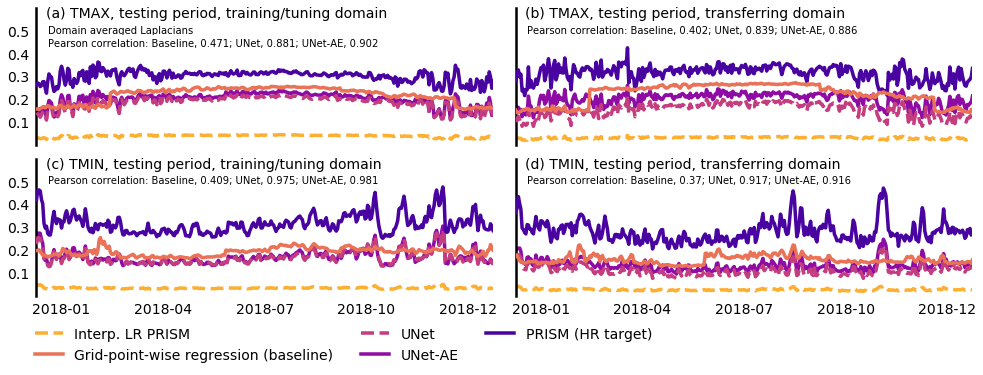

In [24]:
fig, AX = plt.subplots(2, 2, figsize=(13, 4))
plt.subplots_adjust(0, 0, 1, 1, hspace=0.1, wspace=0.05)
AX = AX.ravel()

# ===== Macros ===== #
# line settings
LS = ['--', '-', '--', '-', '-'] # linestyle
Z = [1, 5, 3, 2, 4]; # zorder settings (baseline on the top)
LW = [3.5, 3.5, 3.5, 3.5, 3.5] # linewidth
LIM = [0.6, 0.6, 0.6, 0.6] # yaxis upper bound

# legend labels and titles
model_names = ['Baseline', 'UNet', 'UNet-AE'] # short version of downscaling methods

labels = ['Interp. LR PRISM', 'Grid-point-wise regression (baseline)', 'UNet', 'UNet-AE', 'PRISM (HR target)']
titles = ['(a) TMAX, testing period, training/tuning domain', 
          '(b) TMAX, testing period, transferring domain', 
          '(c) TMIN, testing period, training/tuning domain', 
          '(d) TMIN, testing period, transferring domain']

handle_text = []
ygap = 0.1 # Corr|<--ygap-->|$number
tmax_corr_x = 0.025 #0.275
tmax_corr_y = 0.775 #0.325

tmin_corr_x = 0.025
tmin_corr_y = 0.775

# ===== Background features ===== #
for i, ax in enumerate(AX):
    ax.spines["left"].set_visible(True)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    [j.set_linewidth(2.5) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, 
                   labelbottom=False, left=False, right=False, labelleft=True)
    ax.set_xlim([0, 364]); ax.set_ylim([0, LIM[i]]); ax.set_yticks(np.arange(0.1, LIM[i], 0.1))
    ax.set_title(titles[i], fontsize=14, ha='left', va='top', x=0.02, y=0.965)

AX[0].text(0.025, 0.8, 'Domain averaged Laplacians', ha='left', va='bottom', transform=AX[0].transAxes)
# labels
for ax in [AX[1], AX[3]]:
    ax.tick_params(labelleft=False)
for ax in AX[-2:]:
    #ax.spines["bottom"].set_visible(True)
    ax.tick_params(labelbottom=True)
    ax.set_xticks([0+20, 91+10, 182, 273-10, 364-20])
    ax.set_xticklabels(['2018-01', '2018-04', '2018-07', '2018-10', '2018-12']);
    
# ===== Content ===== #        
count = 0; 
handle = []
# TMAX
for dom in domains:
    for i, key in enumerate(TMAX_keys_pred):
        if count == 0:
            ygap = 0
        else:
            ygap = 0.1
        handle += AX[count].plot(fake_t, TMAX_Lap['{}_{}'.format(key, dom)], 
                                 lw=LW[i], ls=LS[i], color=line_colors[i], zorder=Z[i], label=labels[i])
        handle_text.append(
                    AX[count].text(tmax_corr_x, tmax_corr_y+ygap, 
                    'Pearson correlation: {}, {}; {}, {}; {}, {}'.format(model_names[0], TMAX_Corr['{}_{}'.format(TMAX_keys_r[0], dom)],
                                                    model_names[1], TMAX_Corr['{}_{}'.format(TMAX_keys_r[1], dom)],
                                                    model_names[2], TMAX_Corr['{}_{}'.format(TMAX_keys_r[2], dom)],),
                    va='top', ha='left', fontsize=10, transform=AX[count].transAxes))
    count += 1
# TMIN
ygap = 0.1
for dom in domains:
    for i, key in enumerate(TMIN_keys_pred):
        handle += AX[count].plot(fake_t, TMIN_Lap['{}_{}'.format(key, dom)], 
                                 lw=LW[i], ls=LS[i], color=line_colors[i], zorder=Z[i], label=labels[i])
        handle_text.append(
            AX[count].text(tmin_corr_x, tmin_corr_y+ygap, 
            'Pearson correlation: {}, {}; {}, {}; {}, {}'.format(model_names[0], TMIN_Corr['{}_{}'.format(TMIN_keys_r[0], dom)],
                                            model_names[1], TMIN_Corr['{}_{}'.format(TMIN_keys_r[1], dom)],
                                            model_names[2], TMIN_Corr['{}_{}'.format(TMIN_keys_r[2], dom)],),
            va='top', ha='left', fontsize=10, transform=AX[count].transAxes))
    count += 1
    
for handle_box in handle_text:
    handle_box.set_bbox(dict(facecolor='w', alpha=1, edgecolor='none'))
    
# ===== floating-axis objects ===== #

ax_lg = fig.add_axes([-0.015, -0.075, 0.01, 0.01])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=handle[:5], prop={'size':14}, ncol=3, loc=2, fancybox=False);
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)
LG.get_frame().set_alpha(1)

# Save
fig.savefig(fig_dir+'T2_delta.png', format='png', **fig_keys)

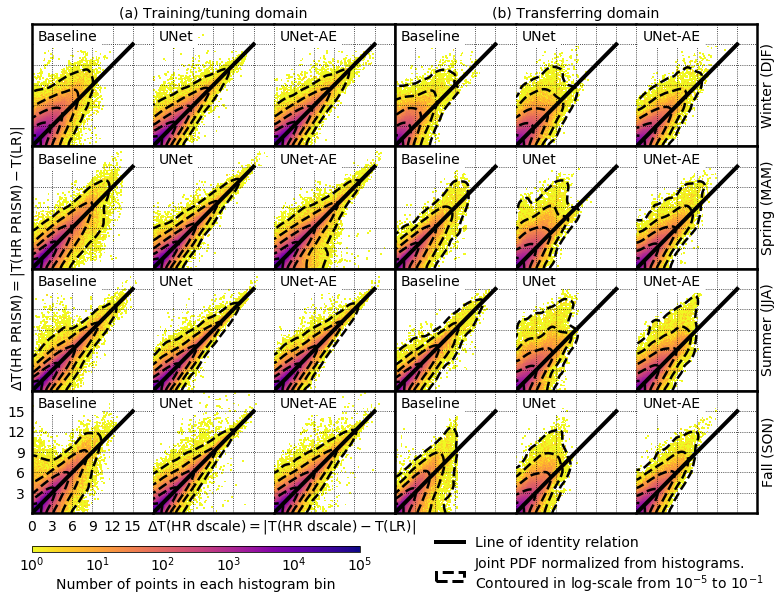

In [25]:
fig, AX = plt.subplots(4, 6, figsize=(13, 9))
plt.subplots_adjust(wspace=0, hspace=0)

# ===== Macros ===== #
TICKS = range(0, TMAX_LIM+3, 3)
for ax in AX.ravel():
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0, TMAX_LIM]); ax.set_xticks(TICKS)
    ax.set_ylim([0, TMAX_LIM]); ax.set_yticks(TICKS)

line_identity = np.linspace(0, TICKS[-2], 100)
edge_ylabels = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)']
model_name = ['Baseline', 'UNet', 'UNet-AE']*2 # display names of the dscale methods
HIST_PLOT_keys = HIST_TMAX_keys*2 # *2 for train and trans domains
# Log axis settings
loglim_bins = [1, 1e5]
loglim_prob = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# subtitle position
title_x = 0.05
title_y = 0.95
# ===== Background features ===== #
AX[-1, 0].tick_params(labelleft=True, labelbottom=True)
AX[-1, 0].set_xticks(TICKS[:-1]) # remove ticks at the edge to avoid axis label overlap
AX[-1, 0].set_yticks(TICKS[1:-1])
# LaTeX form equations
AX[-1, 1].set_xlabel(r'$\mathsf{\Delta T(HR\ dscale) = |T(HR\ dscale) - T(LR)|}$', ha='left', fontsize=14)
AX[-2, 0].set_ylabel(r'$\mathsf{\Delta T(HR\ PRISM) = |T(HR\ PRISM) - T(LR)|}$', ha='left', fontsize=14)
# x-, ylabel coords
AX[-1, 1].xaxis.set_label_coords(-0.05, -0.0375)
AX[-2, 0].yaxis.set_label_coords(-0.0375, 0)
# Overall titles
AX[0][1].set_title('(a) Training/tuning domain', fontsize=14)
AX[0][4].set_title('(b) Transferring domain', fontsize=14)
# special settings for axis at the edge
for i in range(4):
    for j in [0, 1, 3, 4]:
        AX[i][j].spines["right"].set_visible(False)
    for j in [1, 2, 4, 5]:
        AX[i][j].spines["left"].set_visible(False)
        
    AX[i][-1].yaxis.set_label_position("right")
    AX[i][-1].set_ylabel(edge_ylabels[i], fontsize=14)
# ===== Content ===== # 
# loop over 2d histogram calculations
for i, sea in enumerate(seasons):
    for j, key in enumerate(HIST_PLOT_keys):        
        # domain assignment (code needs improve)
        if j < 3:
            dom = 'train'
        else:
            dom = 'trans'
        
        # pcolor panels for bin counts
        CS = AX[i][j].pcolormesh(HIST_TMAX['{}_{}_{}_X'.format(key, sea, dom)], 
                                 HIST_TMAX['{}_{}_{}_Y'.format(key, sea, dom)], 
                                 HIST_TMAX['{}_{}_{}_H'.format(key, sea, dom)], 
                                 norm=colors.LogNorm(vmin=loglim_bins[0], vmax=loglim_bins[1]), cmap=camp_tmax_hist)
        
        # contourf for prob. (gaussian filter applied for looking nicer)
        AX[i][j].contour(HIST_TMAX['{}_{}_{}_X'.format(key, sea, dom)], 
                         HIST_TMAX['{}_{}_{}_Y'.format(key, sea, dom)], 
                         gaussian_filter(HIST_TMAX['{}_{}_{}_P'.format(key, sea, dom)], 4),
                         loglim_prob, colors=('k',), linewidths=(2.5,), linestyles=('--',)) # <-- counterf settings
        
        AX[i][j].plot(line_identity, line_identity, color='k', lw=4, ls='-') # X = Y line
        
        # have to put "grids on" here (zorder issue ?)
        AX[i][j].grid(linestyle=':', color='k')
        
        # title
        handle = AX[i][j].text(title_x, title_y, '{}'.format(model_name[j]), ha='left', va='top', fontsize=14, transform=AX[i][j].transAxes)
        handle.set_bbox(dict(facecolor='w', alpha=1, edgecolor='k', linewidth=0))

        
# ===== floating-axis objects ===== #
# legend (by matplotlib artist)
legend_line = mlines.Line2D([], [], color='k', linewidth=4, label='Line of identity relation')
legend_box = patches.Patch(facecolor='w', edgecolor='k', linewidth=3.0, linestyle='--', \
             label='Joint PDF normalized from histograms.\nContoured in log-scale from $\mathsf{10^{-5}}$ to $\mathsf{10^{-1}}$')
ax_lg = fig.add_axes([0.42, 0.01, 0.5, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[legend_line, legend_box], bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# colorbar
cax = fig.add_axes([0.125, 0.065, 0.35, 0.01]) # 0.53
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.set_label('Number of points in each histogram bin', fontsize=14)
CBar.ax.tick_params(axis='x', labelsize=14, length=0)
CBar.ax.minorticks_off() # no minor ticks

fig.savefig(fig_dir+'T2_hist_1.png', format='png', **fig_keys)

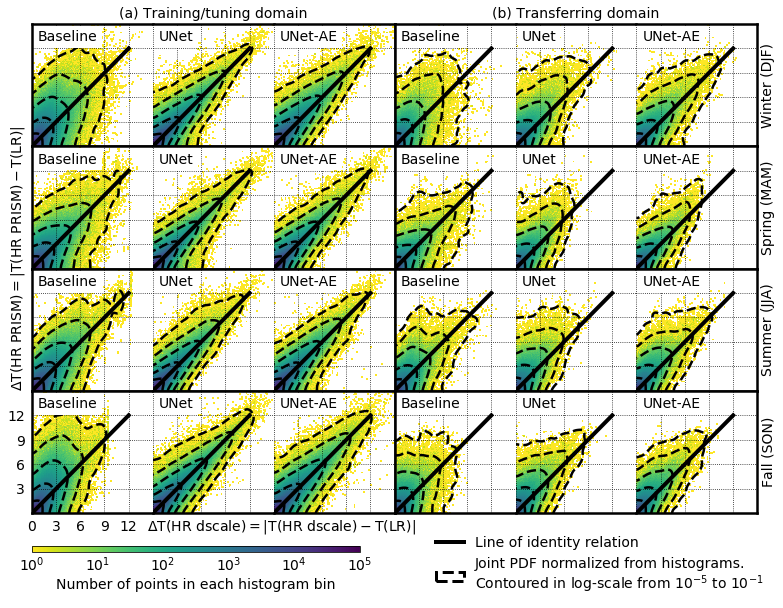

In [26]:
fig, AX = plt.subplots(4, 6, figsize=(13, 9))
plt.subplots_adjust(wspace=0, hspace=0)

# ===== Macros ===== #
TICKS = range(0, TMIN_LIM+3, 3)
for ax in AX.ravel():
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0, TMIN_LIM]); ax.set_xticks(TICKS)
    ax.set_ylim([0, TMIN_LIM]); ax.set_yticks(TICKS)

line_identity = np.linspace(0, TICKS[-2], 100)
edge_ylabels = ['Winter (DJF)', 'Spring (MAM)', 'Summer (JJA)', 'Fall (SON)']
model_name = ['Baseline', 'UNet', 'UNet-AE']*2 # display names of the dscale methods
HIST_PLOT_keys = HIST_TMIN_keys*2 # *2 for train and trans domains
# Log axis settings
loglim_bins = [1, 1e5]
loglim_prob = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
# subtitle position
title_x = 0.05
title_y = 0.95
# ===== Background features ===== #
AX[-1, 0].tick_params(labelleft=True, labelbottom=True)
AX[-1, 0].set_xticks(TICKS[:-1]) # remove ticks at the edge to avoid axis label overlap
AX[-1, 0].set_yticks(TICKS[1:-1])
# LaTeX form equations
AX[-1, 1].set_xlabel(r'$\mathsf{\Delta T(HR\ dscale) = |T(HR\ dscale) - T(LR)|}$', ha='left', fontsize=14)
AX[-2, 0].set_ylabel(r'$\mathsf{\Delta T(HR\ PRISM) = |T(HR\ PRISM) - T(LR)|}$', ha='left', fontsize=14)
# x-, ylabel coords
AX[-1, 1].xaxis.set_label_coords(-0.05, -0.0375)
AX[-2, 0].yaxis.set_label_coords(-0.0375, 0)
# Overall titles
AX[0][1].set_title('(a) Training/tuning domain', fontsize=14)
AX[0][4].set_title('(b) Transferring domain', fontsize=14)
# special settings for axis at the edge
for i in range(4):
    for j in [0, 1, 3, 4]:
        AX[i][j].spines["right"].set_visible(False)
    for j in [1, 2, 4, 5]:
        AX[i][j].spines["left"].set_visible(False)
        
    AX[i][-1].yaxis.set_label_position("right")
    AX[i][-1].set_ylabel(edge_ylabels[i], fontsize=14)
# ===== Content ===== # 
# loop over 2d histogram calculations
for i, sea in enumerate(seasons):
    for j, key in enumerate(HIST_PLOT_keys):        
        # domain assignment (code needs improve)
        if j < 3:
            dom = 'train'
        else:
            dom = 'trans'
        
        # pcolor panels for bin counts
        CS = AX[i][j].pcolormesh(HIST_TMIN['{}_{}_{}_X'.format(key, sea, dom)], 
                                 HIST_TMIN['{}_{}_{}_Y'.format(key, sea, dom)], 
                                 HIST_TMIN['{}_{}_{}_H'.format(key, sea, dom)], 
                                 norm=colors.LogNorm(vmin=loglim_bins[0], vmax=loglim_bins[1]), cmap=camp_tmin_hist)
        
        # contourf for prob. (gaussian filter applied for looking nicer)
        AX[i][j].contour(HIST_TMIN['{}_{}_{}_X'.format(key, sea, dom)], 
                         HIST_TMIN['{}_{}_{}_Y'.format(key, sea, dom)], 
                         gaussian_filter(HIST_TMIN['{}_{}_{}_P'.format(key, sea, dom)], 4),
                         loglim_prob, colors=('k',), linewidths=(2.5,), linestyles=('--',)) # <-- counterf settings
        
        AX[i][j].plot(line_identity, line_identity, color='k', lw=4, ls='-') # X = Y line
        
        # have to put "grids on" here (zorder issue ?)
        AX[i][j].grid(linestyle=':', color='k')
        
        # title
        handle = AX[i][j].text(title_x, title_y, '{}'.format(model_name[j]), ha='left', va='top', fontsize=14, transform=AX[i][j].transAxes)
        handle.set_bbox(dict(facecolor='w', alpha=1, edgecolor='k', linewidth=0))

# ===== floating-axis objects ===== #
# legend (by matplotlib artist)
legend_line = mlines.Line2D([], [], color='k', linewidth=4, label='Line of identity relation')
legend_box = patches.Patch(facecolor='w', edgecolor='k', linewidth=3.0, linestyle='--', \
             label='Joint PDF normalized from histograms.\nContoured in log-scale from $\mathsf{10^{-5}}$ to $\mathsf{10^{-1}}$')
ax_lg = fig.add_axes([0.42, 0.01, 0.5, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=[legend_line, legend_box], bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

# colorbar
cax = fig.add_axes([0.125, 0.065, 0.35, 0.01]) # 0.53
CBar = plt.colorbar(CS, orientation='horizontal', cax=cax) 
CBar.set_label('Number of points in each histogram bin', fontsize=14)
CBar.ax.tick_params(axis='x', labelsize=14, length=0)
CBar.ax.minorticks_off() # no minor ticks

fig.savefig(fig_dir+'T2_hist_2.png', format='png', **fig_keys)